In [1]:
from pyspark.sql import SparkSession 

sc = SparkSession.builder.appName("Visualizando").config("spark.driver.memory", "8g").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/22 01:26:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import pyspark.sql.functions as F

DATA_PATH = "/app/data/"
input_file = DATA_PATH+"dados_log_urna/" 

df = sc.read.parquet(input_file)

df.show()

+--------------------+----------+-------------------+------------------+---------+--------------+---------------+---------------+----------------+---------------+
|             arquivo|id_eleitor|               data|         descricao|Municipio|Zona_Eleitoral|Secao_Eleitoral|erros_ate_agora|sum(erros_tecla)|tempo(segundos)|
+--------------------+----------+-------------------+------------------+---------+--------------+---------------+---------------+----------------+---------------+
|file:///app/data/...|        11|2022-10-02 08:42:46|  Deputado Federal|    16004|            21|             16|              0|               0|             28|
|file:///app/data/...|        11|2022-10-02 08:43:04| Deputado Estadual|    16004|            21|             16|              0|               0|             18|
|file:///app/data/...|        11|2022-10-02 08:43:16|           Senador|    16004|            21|             16|              0|               0|             12|
|file:///app/data/...|

# Erros de Digitação

In [4]:
max_values = df.groupBy("arquivo", "id_eleitor").max("sum(erros_tecla)")
max_values.show()

+--------------------+----------+---------------------+
|             arquivo|id_eleitor|max(sum(erros_tecla))|
+--------------------+----------+---------------------+
|file:///app/data/...|        47|                    2|
|file:///app/data/...|       170|                    4|
|file:///app/data/...|        24|                    0|
|file:///app/data/...|       119|                    0|
|file:///app/data/...|       265|                    0|
|file:///app/data/...|        56|                    0|
|file:///app/data/...|       177|                    0|
|file:///app/data/...|        93|                    3|
|file:///app/data/...|        48|                    1|
|file:///app/data/...|       155|                    2|
|file:///app/data/...|        45|                    3|
|file:///app/data/...|       191|                    0|
|file:///app/data/...|         4|                    8|
|file:///app/data/...|        16|                    4|
|file:///app/data/...|       249|               

In [5]:
erros = max_values.toPandas()
erros.columns = ["arquivo","id_eleitor","max_erros"]
erros

,arquivo,id_eleitor,max_erros
0,file:///app/data/decodificado/o00406-160040021...,47,2
1,file:///app/data/decodificado/o00406-160040021...,170,4
2,file:///app/data/decodificado/o00406-160040021...,24,0
3,file:///app/data/decodificado/o00406-160040021...,119,0
4,file:///app/data/decodificado/o00406-160040021...,265,0
...,...,...,...
2082090,file:///app/data/decodificado/o00406-300310058...,155,6
2082091,file:///app/data/decodificado/o00406-300310058...,207,1
2082092,file:///app/data/decodificado/o00406-300310058...,4,1
2082093,file:///app/data/decodificado/o00406-300310058...,117,1


In [7]:
erros["max_erros"].describe()

count    2.082095e+06
mean     1.850055e+00
std      3.759905e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      4.820000e+02
Name: max_erros, dtype: float64

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from unidecode import unidecode


def plot_box(dados, titulo, salvar, showfliers):
    com_sem = "sem"
    if showfliers:
        com_sem = "com"

    plt.style.use("fivethirtyeight")
    plt.figure(figsize=(10, 6))
    plt.boxplot(dados, showfliers=showfliers)

    plt.title(f"{titulo} ({com_sem} outlier)")
    plt.xticks([]) 
    plt.grid(True)

    if salvar:
        nome_arquivo = unidecode(titulo).lower().replace(" ", "_")
        plt.savefig(f"app/img/box_{nome_arquivo}_outlier.jpg", format="jpg")
    plt.show()

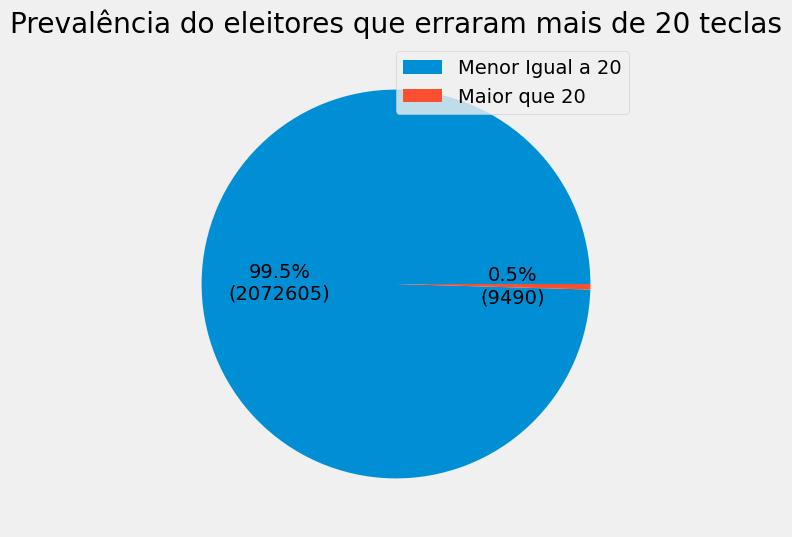

In [95]:
titulo = "Prevalência do eleitores que erraram mais de 20 teclas"
df_pie = erros["max_erros"]
df_pie = (df_pie <= 20).value_counts()
plt.figure(figsize=(10, 6))
plt.pie(df_pie, autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100.*sum(df_pie))})')
plt.legend(loc="best",labels=['Menor Igual a 20', 'Maior que 20']) 
plt.title(titulo)
nome_arquivo = unidecode(titulo).lower().replace(" ", "_")
plt.savefig(f"app/img/pie_{nome_arquivo}.jpg", format="jpg")
plt.show()
del df_pie

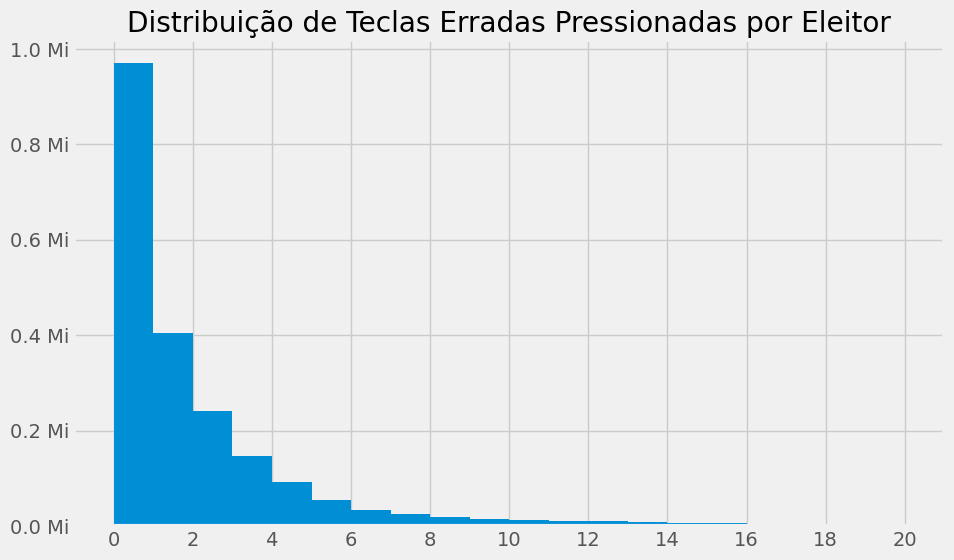

In [84]:
from matplotlib.ticker import FuncFormatter,FixedLocator

def millions_formatter(x, pos):
    return '{:.1f} Mi'.format(x * 1e-6)
titulo = "Distribuição de Teclas Erradas Pressionadas por Eleitor"
nome_arquivo = unidecode(titulo).lower().replace(" ", "_")

df_hist = erros["max_erros"]
df_hist = df_hist[df_hist <= 20]
plt.figure(figsize=(10, 6))
plt.hist(df_hist,bins=20)
plt.title(titulo)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.gca().xaxis.set_major_locator(FixedLocator([i for i in range(0,21,2)]))

plt.savefig(f"app/img/hist_{nome_arquivo}.jpg", format="jpg")
del df_hist
plt.show()

# Tempo de Votação

In [116]:
tempoDeVotacao = (
    df.groupBy("arquivo", "id_eleitor")
    .sum("tempo(segundos)")
    .select("sum(tempo(segundos))")
    .withColumnRenamed("sum(tempo(segundos))", "Tempo de Votação (Segundos)")
)
df_tempoDeVotacao = tempoDeVotacao.toPandas()
df_tempoDeVotacao

,Tempo de Votação (Segundos)
0,77
1,201
2,98
3,73
4,61
...,...
2082090,57
2082091,43
2082092,45
2082093,38


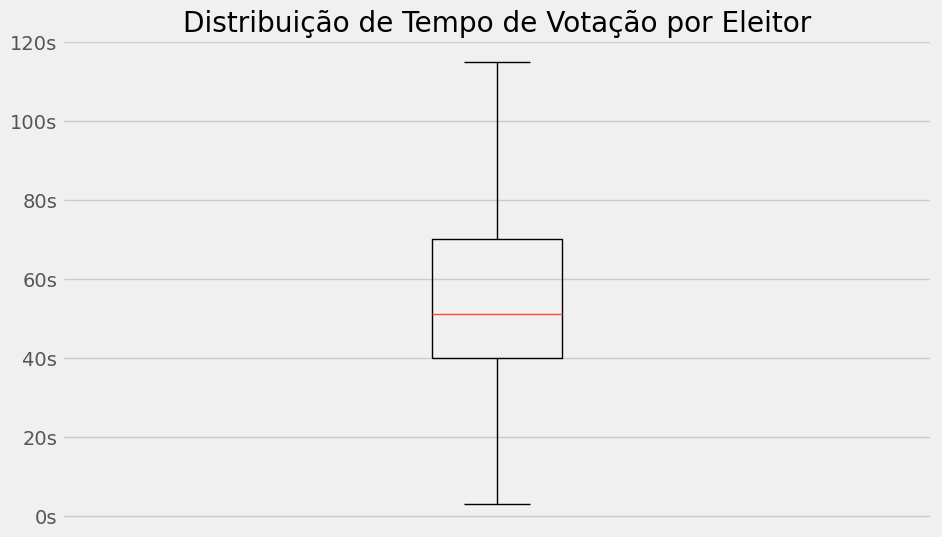

In [129]:
titulo = "Distribuição de Tempo de Votação por Eleitor"
nome_arquivo = unidecode(titulo).lower().replace(" ", "_")

plt.figure(figsize=(10, 6))
box = plt.boxplot(df_tempoDeVotacao["Tempo de Votação (Segundos)"], showfliers=False)
plt.title(titulo)

def segundo_formatar(x, pos):
    return '{:.0f}s'.format(x)

plt.gca().yaxis.set_major_formatter(FuncFormatter(segundo_formatar))

plt.xticks([])
plt.savefig(f"app/img/box_{nome_arquivo}.jpg", format="jpg")
plt.show()

In [ ]:
titulo = "Prevalência do eleitores que erraram mais de 20 teclas"
df_pie = erros["max_erros"]
upper_limit = box['whiskers'][1].get_ydata()[1]
df_pie = (df_pie <= upper_limit).value_counts()
plt.figure(figsize=(10, 6))
plt.pie(df_pie, autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100.*sum(df_pie))})')
plt.legend(loc="best",labels=['Menor Igual a 20', 'Maior que 20']) 
plt.title(titulo)
nome_arquivo = unidecode(titulo).lower().replace(" ", "_")
plt.savefig(f"app/img/pie_{nome_arquivo}.jpg", format="jpg")
plt.show()
del df_pie

In [9]:
#sc.stop()